In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.set_printoptions(precision=4)

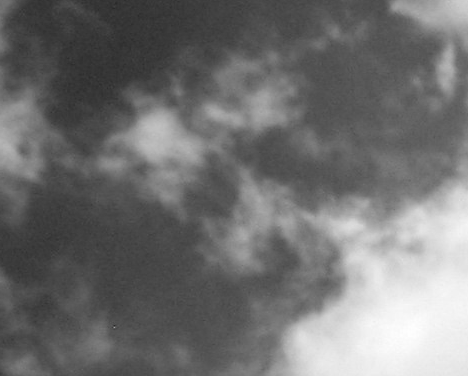

In [3]:
# g === area (big image)
# f === fragment
g = Image.open('img/20160825-143207-156-2_aff_applied.png').convert('L')

wg = g.width // 6
hg = g.height // 6
xg = 200
yg = 200

box = (xg, yg, xg + wg, yg + hg)
g = g.crop(box)
g

In [4]:
print g.size
g_mat = np.asarray(g.getdata(), dtype=np.int8).reshape(g.size[1], g.size[0])

(468, 376)


(100, 100)
188 232


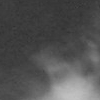

In [5]:
# Crop fragment from area image
wf = 100
hf = 100
# For moving averages computing -- not needed anymore
offset_x = 20
offset_y = 20
xf = np.random.randint(offset_x, g.size[0] - wf - offset_x)
yf = np.random.randint(offset_y, g.size[1] - hf - offset_y)


crop_box = (xf, yf, xf + wf, yf + hf)
f = Image.open("img/20160825-143207-156-1_aff_applied.png").convert('L')
f = f.crop(crop_box)
print f.size
print yf, xf
f

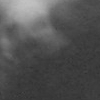

In [6]:
# Create matrix of fragment
f_mat = np.asarray(f.getdata(), dtype=np.int8).reshape(f.size[1], f.size[0])
# Flip matrix
f_mat = np.fliplr(f_mat)
f_mat = np.flipud(f_mat)

Image.fromarray(f_mat, 'L')

In [7]:
num_shades = 256
# Create indicators of f
# of size == g.size
chi = np.zeros((num_shades, g.size[1], g.size[0]), dtype=bool)

In [8]:
# fill the indicators
for h in xrange(f.size[1]):
    for w in xrange(f.size[0]):
        color = f_mat[h, w]
        chi[color, h, w] = True

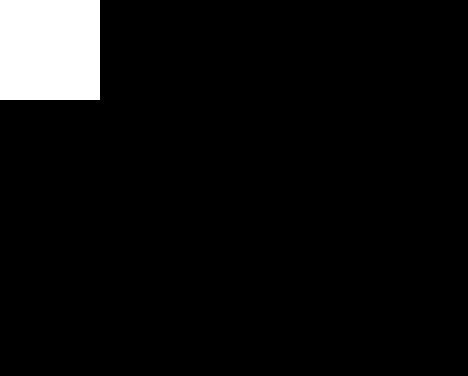

In [9]:
Image.fromarray(chi.sum(axis=0).astype('uint8')*(num_shades - 1), 'L')

In [10]:
# chi_elems[i] === number of pixels that have color "i"
chi_elems = np.array( f.histogram() )
print chi_elems

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   1   3   2  13  22  24
  97 173 265 373 507 614 562 540 412 375 243 175 156 145 165 204 145 142
 165 184 154 151 161 180 123 118 103  91  85  84  83  60  53  68  77  56
  65  62  61  58  49  54  57  51  55  52  48  59  49  59  50  51  40  30
  54  43  39  44  43  45  42  54  40  25  31  30  29  27  25  15  17  20
  14  11  16  13  23  15   8  15  13  15  21  11   7   7  17  17  14   8
  11  15  10  21   8  17  11  14  13  18  23  14  24  12  14  21  14  17
  17  23  16  21  15  18  17  13  14  19  19  14  17  20  19  20  24  16
  15  18  18  12  17  18  11   9  27  14  18  19  15  14   4   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [11]:
fft_chi = np.fft.fft2(chi)

In [12]:
fft_g = np.fft.fft2(g_mat)

In [13]:
# Scalar product (g_frag, chi[i])
sp_g_frag_chi = np.zeros((num_shades, g.size[1] - hf, g.size[0] - wf))

for i in xrange(num_shades):
    if chi_elems[i] > 0:
        sp_g_frag_chi[i] = np.fft.ifft2(fft_g * fft_chi[i])[hf:, wf:]

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: ComplexWarning: Casting complex values to real discards the imaginary part


In [14]:
# || Projection of g_frag on f ||^2
norm_pr_gfrag_sqr = np.zeros((g.size[1] - hf, g.size[0] - wf))
for i in xrange(num_shades):
    if chi_elems[i] > 0:
        norm_pr_gfrag_sqr += sp_g_frag_chi[i] ** 2 / float(chi_elems[i])
        

norm_pr_gfrag_sqr = abs(norm_pr_gfrag_sqr)

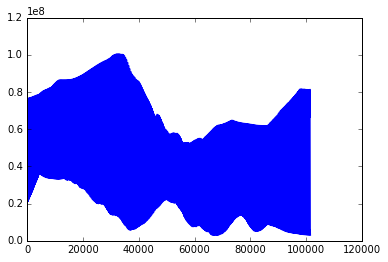

In [15]:
plt.plot(norm_pr_gfrag_sqr.ravel())

In [16]:
w_norm = norm_pr_gfrag_sqr.shape[1]
idx_pr = norm_pr_gfrag_sqr.argmax()
true_idx = xf - 1 + (yf - 1) * w_norm
print 'idx Should be: ', true_idx
print idx_pr
print idx_pr // w_norm + 1, idx_pr % w_norm + 1

idx Should be:  69047
32725
89 342


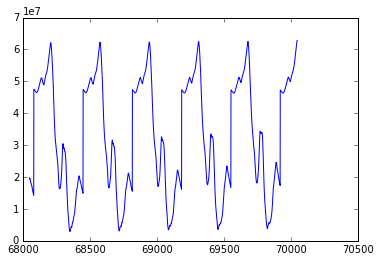

In [17]:
plt.plot(np.arange(max(0, true_idx - 1000), true_idx + 1000), 
         norm_pr_gfrag_sqr.ravel()[max(0, true_idx - 1000) : true_idx + 1000])

In [18]:
# chi_X -- const field of vision
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 0 0 0 0 0 ... 0
# . . .
# 0 0 0 0 0 ... 0
chi_X = np.zeros((g.size[1], g.size[0]), dtype=bool)
chi_X[:hf, :wf] = np.ones((hf, wf))

# || g ||^2
fft_gsqr = np.fft.fft2(g_mat ** 2)
fft_chi_X = np.fft.fft2(chi_X)
norm_gfrag_sqr = np.fft.ifft2(fft_gsqr * fft_chi_X)[hf:, wf:].astype('float')

norm_gfrag_sqr = abs(norm_gfrag_sqr)

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part


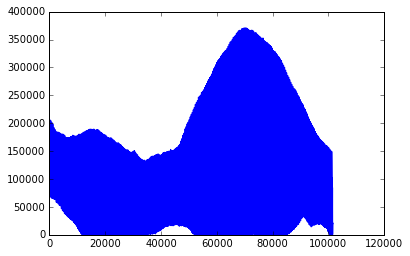

In [19]:
plt.plot(norm_gfrag_sqr.ravel())

In [20]:
# E_gfrag = np.fft.ifft2(fft_g * fft_chi_X)[hf:, wf:].astype('float')
norm_E_gfrag_sqr = np.fft.ifft2(fft_g * fft_chi_X)[hf:, wf:].astype('float') \
                        ** 2 / (hf * wf)

norm_E_gfrag_sqr = abs(norm_E_gfrag_sqr)

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


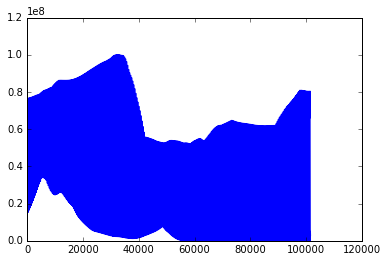

In [21]:
plt.plot(norm_E_gfrag_sqr.ravel())

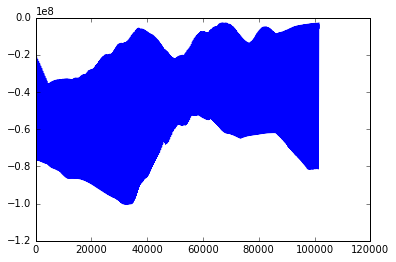

In [22]:
numerator = norm_gfrag_sqr - norm_pr_gfrag_sqr
plt.plot(numerator.ravel())

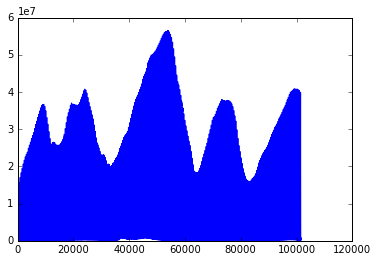

In [23]:
denominator = norm_pr_gfrag_sqr - norm_E_gfrag_sqr
plt.plot(denominator.ravel())

idx Should be:  69047
53724
346 565
188 232


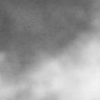

In [24]:
w_norm = norm_pr_gfrag_sqr.shape[1]
idx_denom = denominator.ravel().argmax()
true_idx = xf - 1 + (yf - 1) * w_norm
print 'idx Should be: ', true_idx
print idx_denom
y_denom, x_denom = idx_denom // w_norm + 1, idx_denom % w_norm + 1

print yg + y_denom, xg + x_denom
print yf, xf

Image.fromarray(g_mat[y_denom : y_denom + hf, x_denom : x_denom + wf], 'L')

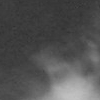

In [25]:
f

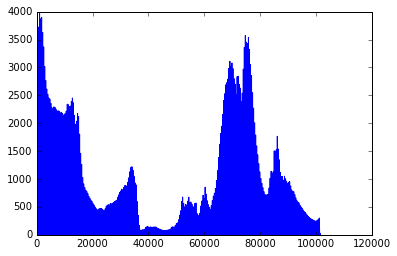

In [26]:
tau = abs(numerator) / abs(denominator)
plt.plot(tau.ravel())

In [27]:
index = tau.argmin() 
x_min = index % tau.shape[1] + 1
y_min = index // tau.shape[1] + 1
print index
print 'Should be:', true_idx
print "y_min, x_min: %d %d" % (y_min, x_min)
print 'Should be:', (yf, xf)

83081
Should be: 69047
y_min, x_min: 226 282
Should be: (188, 232)


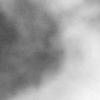

In [28]:
Image.fromarray(g_mat[y_min : y_min + hf , x_min : x_min + wf], 'L')